#  Mammographic Mass Data Set

- ML problem: Classification
- Motivation: ML models can automate the classification of breast masses, for earlier detection and treatment.






### Libraries

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, ConfusionMatrixDisplay,log_loss, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import os
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

### Data exploration and pre-processing

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes)



1. BI-RADS assessment: 1 to 5 (ordinal, **non-predictive!**)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [81]:
data = pd.read_csv('mammographic_masses.data', na_values='?', header=None, names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']) 
data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [82]:
## Eliminating "BI-RADS" column

data = data.drop('BI-RADS', axis=1)
data.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [83]:
## Missing values

data.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

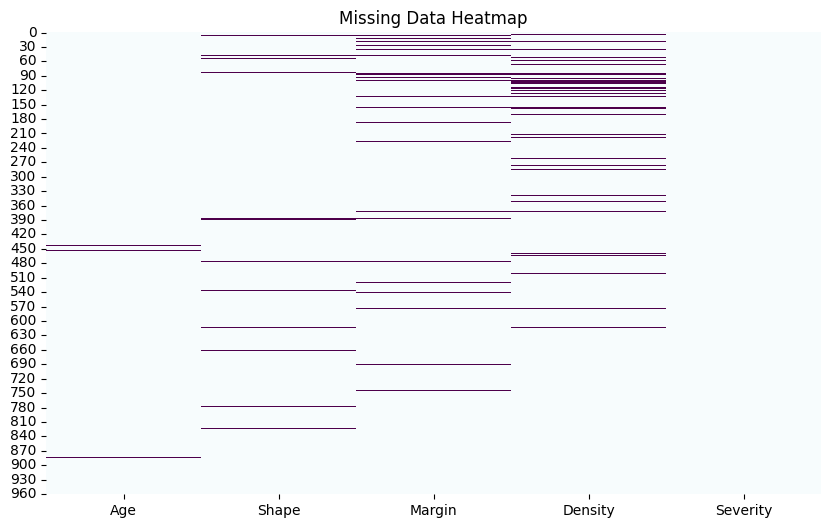

In [84]:
## Heatmap to visualize missing values

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='BuPu')
plt.title('Missing Data Heatmap')
plt.show()

In [85]:
## Percentage of examples with missing values

rows_with_nan = data.isnull().any(axis=1).sum()

percent_unique_missing_rows = (rows_with_nan / len(data)) * 100

print(f"{percent_unique_missing_rows:.0f} %")

14 %


In [86]:
## Eliminating missing values, less than 20% of total dataset examples

df = data.dropna().reset_index(drop=True)
df

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1
1,58.0,4.0,5.0,3.0,1
2,28.0,1.0,1.0,3.0,0
3,57.0,1.0,5.0,3.0,1
4,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
826,47.0,2.0,1.0,3.0,0
827,56.0,4.0,5.0,3.0,1
828,64.0,4.0,5.0,3.0,0
829,66.0,4.0,5.0,3.0,1


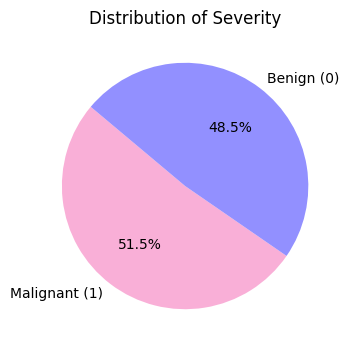

In [87]:
## Severity distribution

plt.figure(figsize=(4,4))
plt.pie(df['Severity'].value_counts(), labels=['Malignant (1)', 'Benign (0)'], autopct='%1.1f%%', startangle=140, colors=['#f9afd7ff','#9290ffff'])
plt.title('Distribution of Severity')
plt.show()

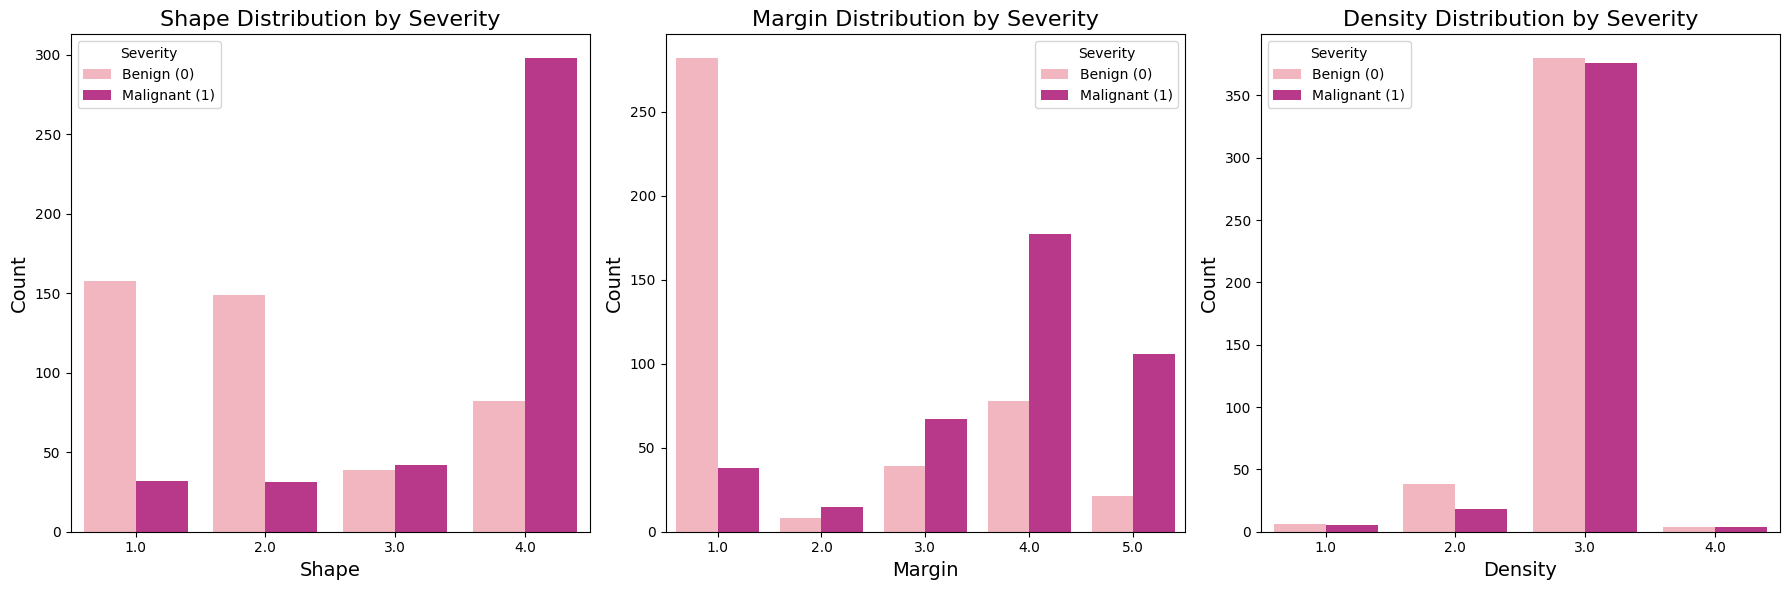

In [88]:
plt.figure(figsize=(18, 6))
for i, col in enumerate(['Shape', 'Margin', 'Density'], 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue='Severity', palette='RdPu')
    plt.title(f'{col} Distribution by Severity', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Severity', labels=['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# margin and shape seem to be strong indicators of severity

In [89]:
## One-hot encode ordinal variables

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[['Shape', 'Margin', 'Density']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Shape', 'Margin', 'Density']))

df_encoded = pd.concat([df[['Age']], one_hot_df, df[['Severity']]], axis=1)

print(df_encoded.shape)
df_encoded.head()

(831, 15)


,Age,Shape_1.0,Shape_2.0,Shape_3.0,Shape_4.0,Margin_1.0,Margin_2.0,Margin_3.0,Margin_4.0,Margin_5.0,Density_1.0,Density_2.0,Density_3.0,Density_4.0,Severity
0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,58.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,76.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


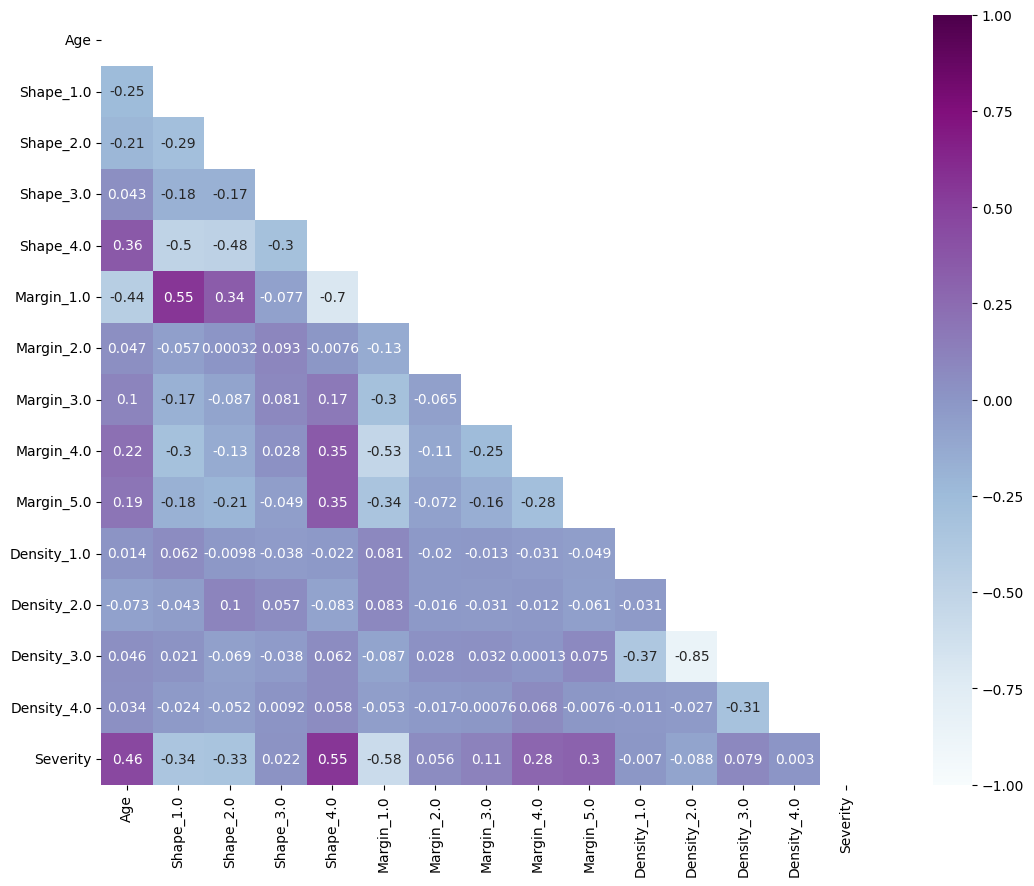

In [90]:
## Correlation matrix
plt.figure(figsize=(16, 10))
correlation_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

axis_corr = sns.heatmap(
correlation_matrix,
mask=mask,
vmin=-1, vmax=1, center=0,
cmap= 'BuPu',
annot=True,
square= True
)

plt.show() 

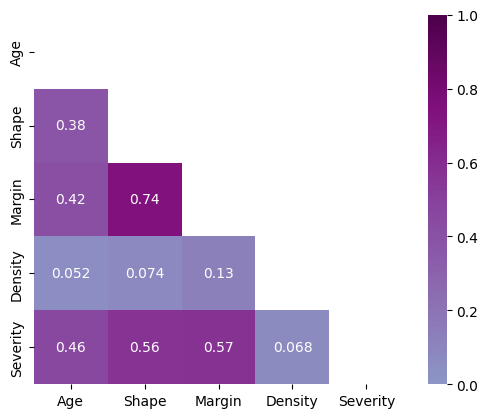

In [91]:
## Correlation matrix

correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
axis_corr = sns.heatmap(
correlation_matrix,
mask=mask,
vmin=0, vmax=1, center=0,
cmap= 'BuPu',
annot=True,
square=True
)

plt.show() 

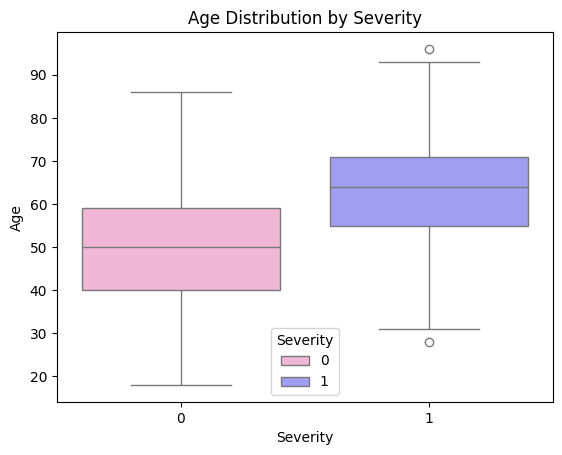

In [92]:
sns.boxplot(x='Severity', y='Age', data=df_encoded,hue='Severity',
            palette={0: '#f9afd7ff', 1: '#9290ffff'})
plt.title('Age Distribution by Severity')

plt.show()

### Model

- Logistic Regression (with Regularization)
- Support Vector Machine (SVM)
- Neural Networks

In [ ]:
## X and y

X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']

print(X.shape)
print(y.shape)


(831, 14)
(831,)


In [94]:
#Setting a random seed ensures that the model produces the same results when run multiple times with the same data and configurations
seed = 42
np.random.seed(seed)
random.seed(seed)

### split to train and test and then do the cv on train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [95]:
## All models: scaling and splits

scaler = ColumnTransformer([
    ('age_scaler', StandardScaler(), ['Age'])
], remainder='passthrough',force_int_remainder_cols=False)  # Keep other columns, just normalize age

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [96]:
## Logistic Regression

pipeline_logreg = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [97]:
## Hyperparameter Tuning

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Penalty
    'logreg__solver': ['liblinear', 'saga']  # Solvers compatible with penalties
}

grid_search_logreg = GridSearchCV(pipeline_logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

best_params = grid_search_logreg.best_params_
print(f"Best Hyperparameters (Logistic Regression): {best_params}")

Best Hyperparameters (Logistic Regression): {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}


In [98]:
## Train with best parameters

best_logreg = grid_search_logreg.best_estimator_ 
best_logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('age_scaler',
                                                  StandardScaler(),
                                                  ['Age'])])),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=1000, solver='saga'))])

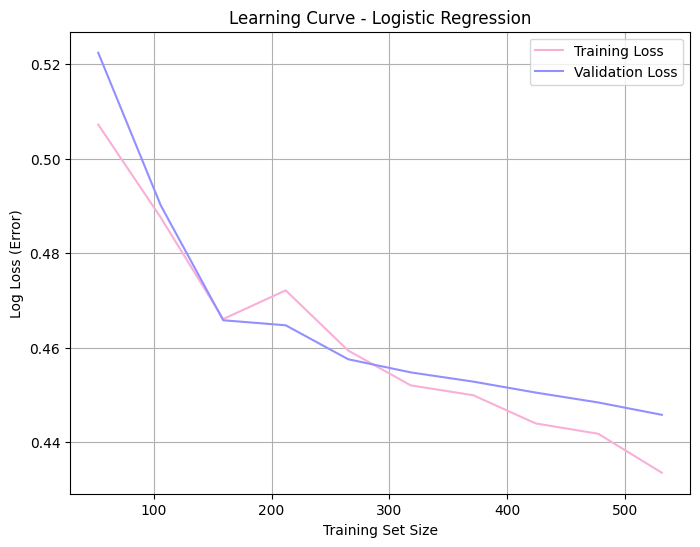

In [99]:
## Learning Curve

train_sizes, train_scores, val_scores = learning_curve(
    best_logreg, X_train, y_train,train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)  # convert to positive log loss
val_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='#f9afd7ff', label="Training Loss")
plt.plot(train_sizes, val_mean, color='#9290ffff', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (Error)")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [100]:
logreg_model = best_logreg.named_steps['logreg']
solver_params = logreg_model.get_params()
print(f"Solver: {solver_params}")
n_iterations = logreg_model.n_iter_[0]
print(f"Converged in {n_iterations} iterations")

Solver: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Converged in 16 iterations


Train Accuracy (Logistic Regression): 0.8268
Test Accuracy (Logistic Regression): 0.7784


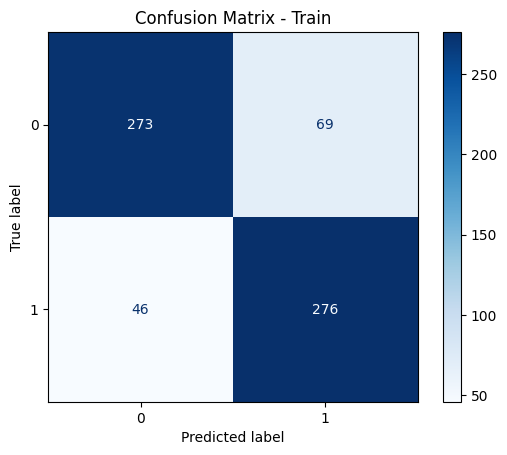

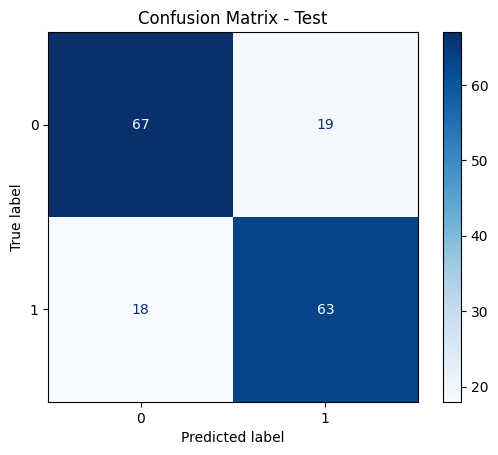

In [101]:
# Predict on train and test
y_train_pred = best_logreg.predict(X_train)
logreg_pred = best_logreg.predict(X_test)

y_train_pred_lr = y_train_pred

# Accuracy on train and test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, logreg_pred)

print(f"Train Accuracy (Logistic Regression): {train_accuracy:.4f}")
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")

# Confusion Matrix on train and test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, logreg_pred)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()

Train ROC AUC (Logistic Regression): 0.8807
Test ROC AUC (Logistic Regression): 0.8508


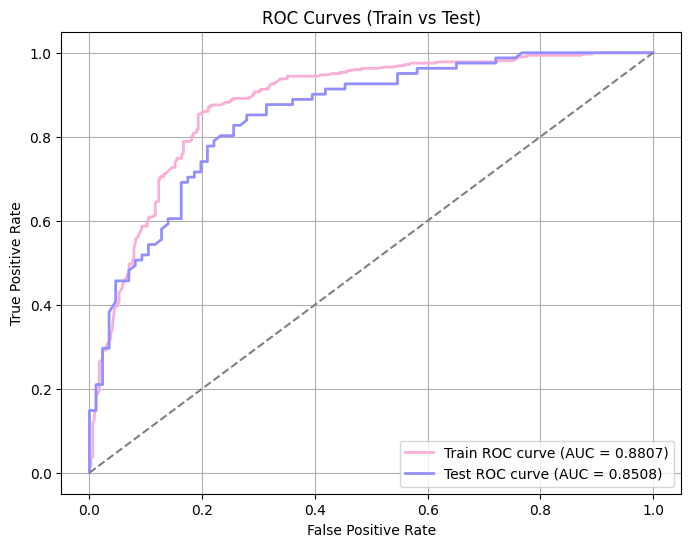

In [102]:
## ROC curves
# predicted probabilities for the positive class (Malignant = 1)
y_train_prob = best_logreg.predict_proba(X_train)[:, 1]
y_test_prob = best_logreg.predict_proba(X_test)[:, 1]

# train set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test_logreg = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (Logistic Regression): {roc_auc_train:.4f}")
print(f"Test ROC AUC (Logistic Regression): {roc_auc_test_logreg:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color= '#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_logreg:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### SVM

In [103]:
pipeline_svm = Pipeline([
    ('scaler', scaler),
    ('svm', SVC(kernel='rbf', probability=True))
])


In [104]:
#Hyperparameter tunning
param_grid = {
    'svm__C': [0.01,0.1, 1, 10],  # Regularization
    'svm__gamma': ['scale', 'auto', 0.01, 0.001]  # Scales for kernel RBF
}

grid_search_svm = GridSearchCV(pipeline_svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print(f"Best Hyperparameters (SVM): {grid_search_svm.best_params_}")

Best Hyperparameters (SVM): {'svm__C': 0.1, 'svm__gamma': 'auto'}


In [105]:
## Train with best parameters

best_svm = grid_search_svm.best_estimator_ 
best_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('age_scaler',
                                                  StandardScaler(),
                                                  ['Age'])])),
                ('svm', SVC(C=0.1, gamma='auto', probability=True))])

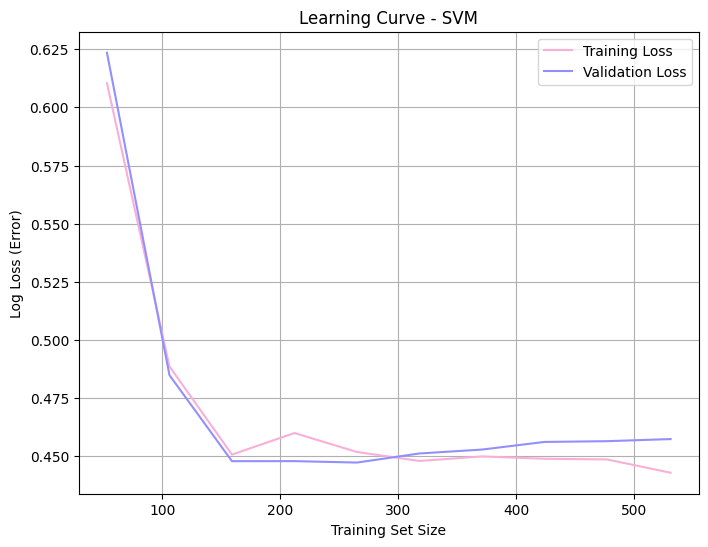

In [106]:
## Learning Curve

train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_train, y_train,train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)  # convert to positive log loss
val_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='#f9afd7ff', label="Training Loss")
plt.plot(train_sizes, val_mean, color='#9290ffff', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (Error)")
plt.title("Learning Curve - SVM")
plt.legend()
plt.grid()
plt.show()

Train Accuracy (SVM): 0.8193
Test Accuracy (SVM): 0.7725


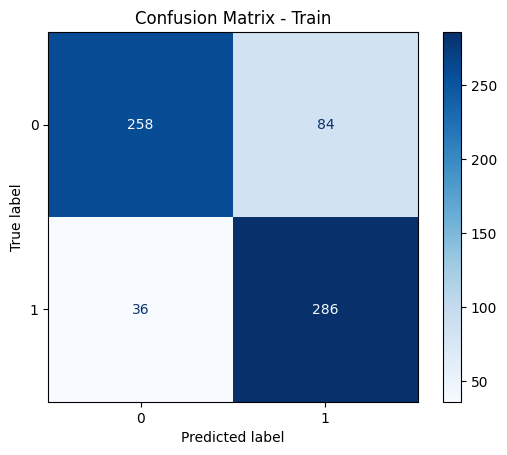

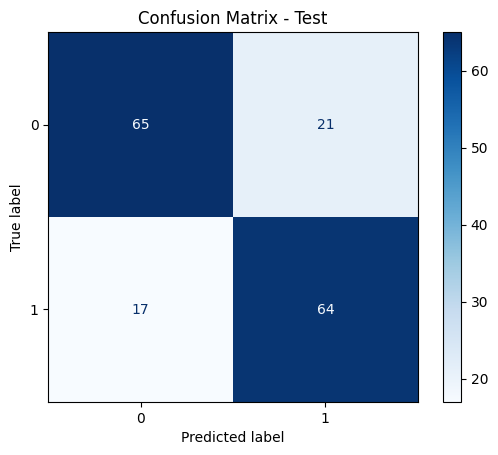

In [107]:
# Predict on train and test
y_train_pred = best_svm.predict(X_train)
svm_pred = best_svm.predict(X_test)

# Accuracy on train and test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, svm_pred)

print(f"Train Accuracy (SVM): {train_accuracy:.4f}")
print(f"Test Accuracy (SVM): {test_accuracy:.4f}")

# Confusion Matrix on train and test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, svm_pred)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()


Train ROC AUC (Logistic Regression): 0.8682
Test ROC AUC (Logistic Regression): 0.8378


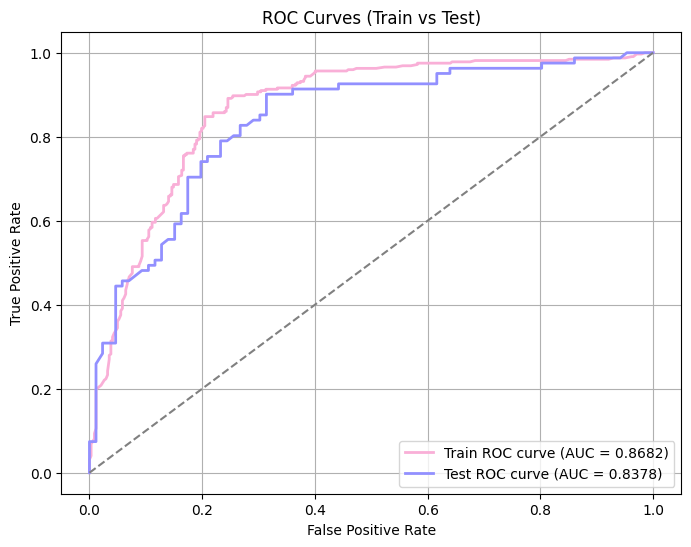

In [108]:
## ROC curves
# predicted probabilities for the positive class (Malignant = 1)
y_train_prob = best_svm.predict_proba(X_train)[:, 1]
y_test_prob = best_svm.predict_proba(X_test)[:, 1]

# train set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test_svm = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (Logistic Regression): {roc_auc_train:.4f}")
print(f"Test ROC AUC (Logistic Regression): {roc_auc_test_svm:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color= '#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_svm:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Neural Networks

In [109]:
pipeline_mlp = Pipeline([
    ('scaler', scaler),  
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=10000, random_state=42))
])

In [110]:
## Hyperparameter Tuning

param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50),(25,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [0.01,0.1,0.5,0.05,0.6],  
}

grid_search_nn = GridSearchCV(pipeline_mlp, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_nn.fit(X_train, y_train)

best_params = grid_search_nn.best_params_
print(f"Best Hyperparameters (NN): {best_params}")

Best Hyperparameters (NN): {'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (50,), 'mlp__solver': 'adam'}


In [111]:
## Train with best parameters

best_nn = grid_search_nn.best_estimator_ 
# best_nn.fit(X_train, y_train)

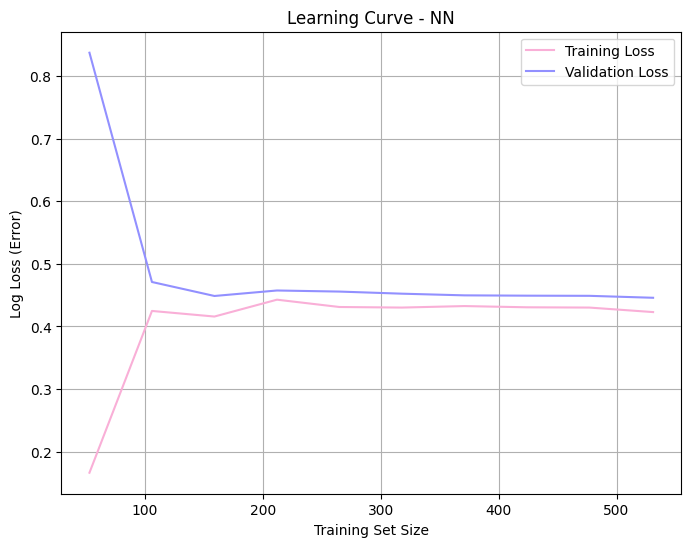

In [112]:
## Learning Curve

train_sizes, train_scores, val_scores = learning_curve(
    best_nn, X_train, y_train,train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)  # convert to positive log loss
val_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='#f9afd7ff', label="Training Loss")
plt.plot(train_sizes, val_mean, color='#9290ffff', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (Error)")
plt.title("Learning Curve - NN")
plt.legend()
plt.grid()
plt.show()

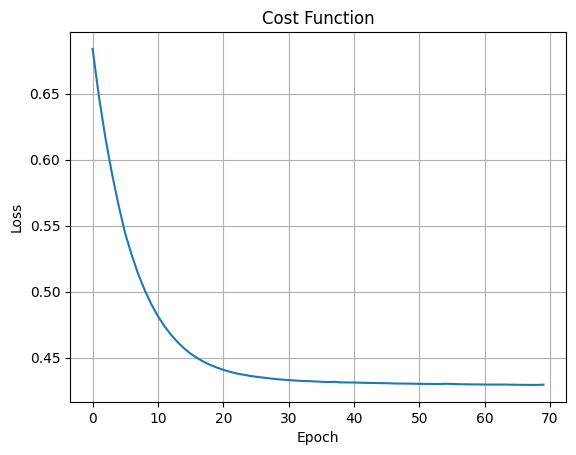

In [113]:
## Loss funtion for training set

mlp_model = best_nn.named_steps['mlp']
loss_curve = mlp_model.loss_curve_

plt.plot(loss_curve)
plt.title("Cost Function")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Train Accuracy (Logistic Regression): 0.8253
Test Accuracy (Logistic Regression): 0.7784


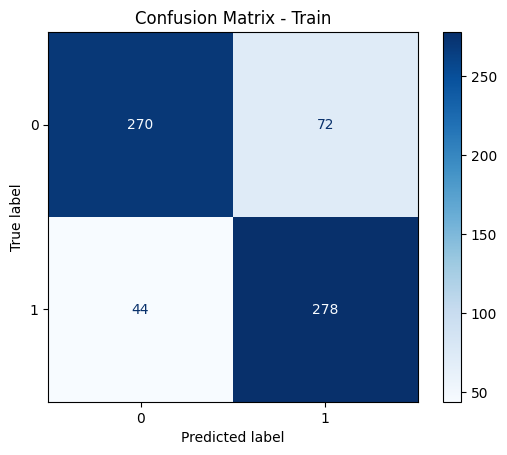

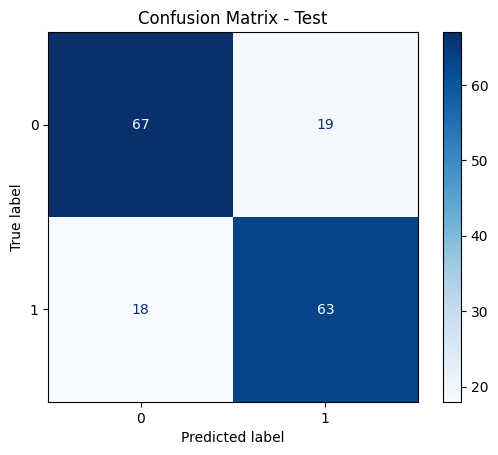

In [114]:
# Predict on train and test
y_train_pred = best_nn.predict(X_train)
nn_pred = best_nn.predict(X_test)

# Accuracy on train and test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, nn_pred)

print(f"Train Accuracy (Logistic Regression): {train_accuracy:.4f}")
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")

# Confusion Matrix on train and test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, nn_pred)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()

Train ROC AUC (Logistic Regression): 0.8825
Test ROC AUC (Logistic Regression): 0.8455


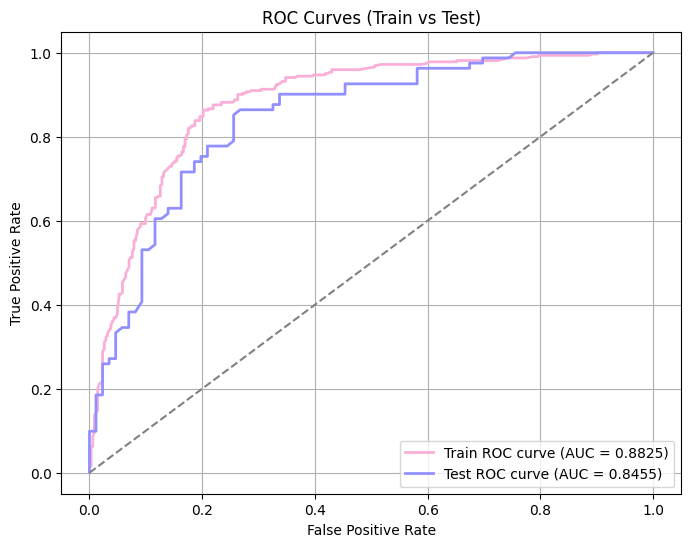

In [115]:
## ROC curves
# predicted probabilities for the positive class (Malignant = 1)
y_train_prob = best_nn.predict_proba(X_train)[:, 1]
y_test_prob = best_nn.predict_proba(X_test)[:, 1]

# train set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test_nn = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (Logistic Regression): {roc_auc_train:.4f}")
print(f"Test ROC AUC (Logistic Regression): {roc_auc_test_nn:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color= '#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_nn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Decision Tree

In [116]:
pipeline_dt = Pipeline([
    ('scaler', scaler),  # Scaling only for consistency, though not strictly necessary for Decision Trees
    ('dt', DecisionTreeClassifier(random_state=seed))
])

In [117]:
# Hyperparameter Tuning
param_grid_dt = {
    'dt__criterion': ['gini', 'entropy'],  # Splitting criteria
    'dt__max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'dt__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'dt__min_samples_leaf': [1, 2, 5]  # Minimum samples required to be at a leaf node
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Best Hyperparameters
best_params_dt = grid_search_dt.best_params_
print(f"Best Hyperparameters (Decision Tree): {best_params_dt}")

Best Hyperparameters (Decision Tree): {'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 2}


In [118]:
# Train with Best Parameters
best_dt = grid_search_dt.best_estimator_
best_dt.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('age_scaler',
                                                  StandardScaler(),
                                                  ['Age'])])),
                ('dt',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        random_state=42))])

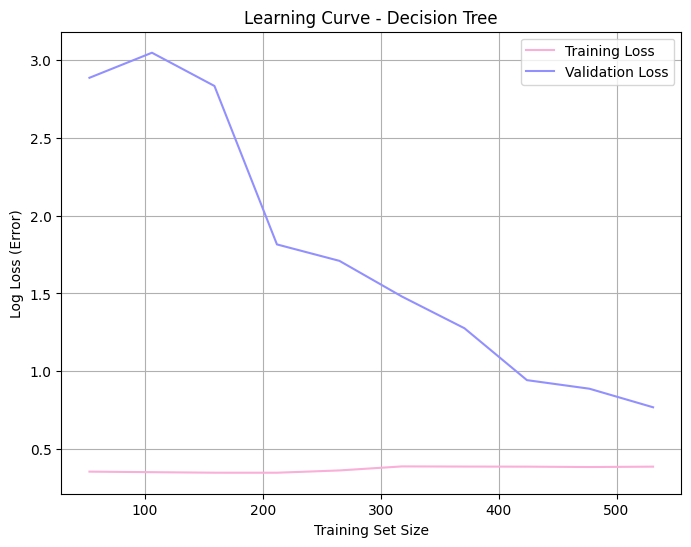

In [119]:
## Learning Curve

train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train,train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)  # convert to positive log loss
val_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='#f9afd7ff', label="Training Loss")
plt.plot(train_sizes, val_mean, color='#9290ffff', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (Error)")
plt.title("Learning Curve - Decision Tree")
plt.legend()
plt.grid()
plt.show()

Train Accuracy (Decision Tree): 0.8343
Test Accuracy (Decision Tree): 0.7725


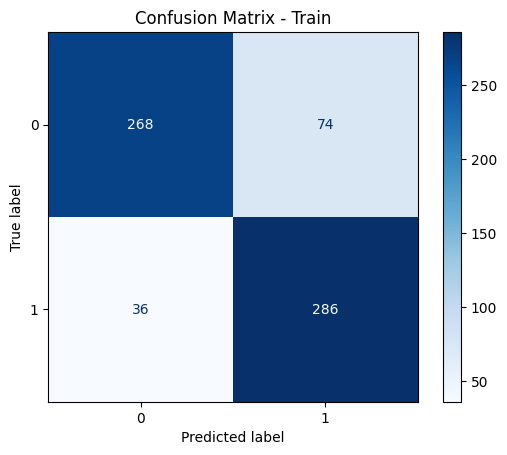

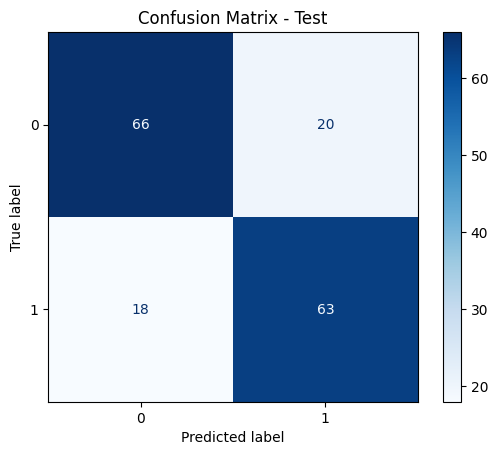

In [120]:
# Predict on Train and Test
y_train_pred = best_dt.predict(X_train)
dt_pred = best_dt.predict(X_test)

# Accuracy on Train and Test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, dt_pred)

print(f"Train Accuracy (Decision Tree): {train_accuracy:.4f}")
print(f"Test Accuracy (Decision Tree): {test_accuracy:.4f}")

# Confusion Matrix on Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, dt_pred)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()

Train ROC AUC (Decision Tree): 0.8919
Test ROC AUC (Decision Tree): 0.8404


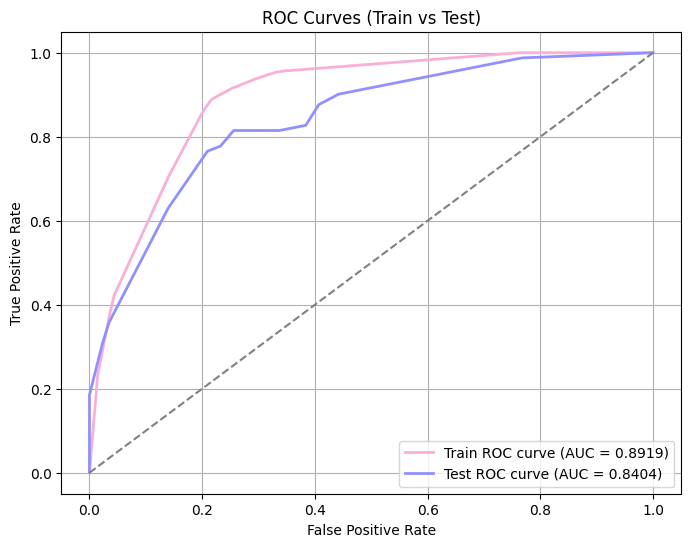

In [121]:
# ROC Curves
y_train_prob = best_dt.predict_proba(X_train)[:, 1]
y_test_prob = best_dt.predict_proba(X_test)[:, 1]

# Train Set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Test Set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test_dt = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (Decision Tree): {roc_auc_train:.4f}")
print(f"Test ROC AUC (Decision Tree): {roc_auc_test_dt:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_dt:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Model Performance Comparison

In [122]:
# Logistic Regression
logreg_metrics = {
    'Accuracy': accuracy_score(y_test, logreg_pred),
    'Precision': precision_score(y_test, logreg_pred),
    'Recall': recall_score(y_test, logreg_pred),
    'F1 Score': f1_score(y_test, logreg_pred),
    'AUC': roc_auc_test_logreg
}

# SVM
svm_metrics = {
    'Accuracy': accuracy_score(y_test, svm_pred),
    'Precision': precision_score(y_test, svm_pred),
    'Recall': recall_score(y_test, svm_pred),
    'F1 Score': f1_score(y_test, svm_pred),
    'AUC': roc_auc_test_svm
}

# NN
nn_metrics = {
    'Accuracy': accuracy_score(y_test, nn_pred),
    'Precision': precision_score(y_test, nn_pred),
    'Recall': recall_score(y_test, nn_pred),
    'F1 Score': f1_score(y_test, nn_pred),
    'AUC': roc_auc_test_nn
}

# DT
dt_metrics = {
    'Accuracy': accuracy_score(y_test, dt_pred),
    'Precision': precision_score(y_test, dt_pred),
    'Recall': recall_score(y_test, dt_pred),
    'F1 Score': f1_score(y_test, dt_pred),
    'AUC': roc_auc_test_dt
}

metrics_table = pd.DataFrame([
    {'Model': 'Logistic Regression', **logreg_metrics},
    {'Model': 'SVM', **svm_metrics},
    {'Model': 'Neural Network', **nn_metrics},
    {'Model': 'Decision Tree', **dt_metrics}
])

metrics_table = metrics_table.round(4)
metrics_table.set_index('Model', inplace=True)

styled_table = metrics_table.style.highlight_max(axis=0, color='lightgreen') \
                                .format("{:.4f}")

styled_table

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Logistic Regression,0.7784,0.7683,0.7778,0.7730,0.8508
SVM,0.7725,0.7529,0.7901,0.7711,0.8378
Neural Network,0.7784,0.7683,0.7778,0.7730,0.8455
Decision Tree,0.7725,0.7590,0.7778,0.7683,0.8404


## Dropping density

Testing again Logistic Regression and SVM

In [132]:
## Drop density
data_nodensity = data.drop(columns='Density')

## Percentage of examples with missing values

rows_with_nan = data_nodensity.isnull().any(axis=1).sum()

percent_unique_missing_rows = (rows_with_nan / len(data_nodensity)) * 100

print(f"{percent_unique_missing_rows:.0f} %") ## 8%

## Drop the Nan
data_nan = data_nodensity.dropna().reset_index(drop=True)
data_nan

## One-hot encode ordinal variables

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(data_nan[['Shape', 'Margin']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Shape', 'Margin']))

df_encoded = pd.concat([data_nan[['Age']], one_hot_df, data_nan[['Severity']]], axis=1)

print(df_encoded.shape)
df_encoded.head()

## Divite into X and y

X_no_density = df_encoded.drop('Severity', axis=1)
X_no_density = X_no_density.drop(columns=[col for col in df_encoded.columns if 'Density' in col])
y_no_density = df_encoded['Severity']

X_train_no_density, X_test_no_density, y_train_no_density, y_test_no_density = train_test_split(X_no_density, y_no_density, test_size=0.2, random_state=seed, stratify=y_no_density)

X_no_density.head()

8 %
(887, 11)


,Age,Shape_1.0,Shape_2.0,Shape_3.0,Shape_4.0,Margin_1.0,Margin_2.0,Margin_3.0,Margin_4.0,Margin_5.0
0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,43.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [133]:
## Logistic Regression

pipeline_logreg_no_density = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Penalty
    'logreg__solver': ['liblinear', 'saga']  # Solvers compatible with penalties
}

grid_search_logreg_no_density = GridSearchCV(pipeline_logreg_no_density, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_logreg_no_density.fit(X_train_no_density, y_train_no_density)

best_params_no_density = grid_search_logreg_no_density.best_params_
print(f"Best Hyperparameters (Logistic Regression): {best_params_no_density}")

Best Hyperparameters (Logistic Regression): {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}


Train Accuracy (Logistic Regression): 0.8110
Test Accuracy (Logistic Regression): 0.8202


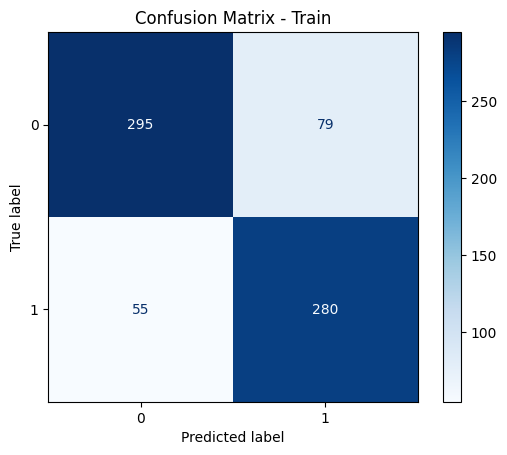

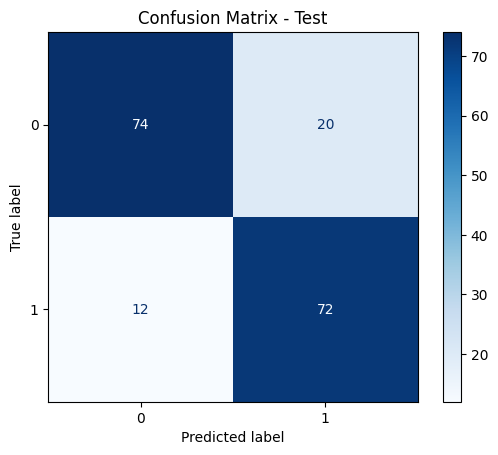

In [134]:
best_logreg_no_density = grid_search_logreg_no_density.best_estimator_ 
best_logreg_no_density.fit(X_train_no_density, y_train_no_density)

# Predict on train and test
y_train_pred = best_logreg_no_density.predict(X_train_no_density)
logreg_pred_no_density = best_logreg_no_density.predict(X_test_no_density)

# Accuracy on train and test
train_accuracy = accuracy_score(y_train_no_density, y_train_pred)
test_accuracy = accuracy_score(y_test_no_density, logreg_pred_no_density)

print(f"Train Accuracy (Logistic Regression): {train_accuracy:.4f}")
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")

# Confusion Matrix on train and test
train_cm = confusion_matrix(y_train_no_density, y_train_pred)
test_cm = confusion_matrix(y_test_no_density, logreg_pred_no_density)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()

Train ROC AUC (Logistic Regression): 0.8719
Test ROC AUC (Logistic Regression): 0.8926


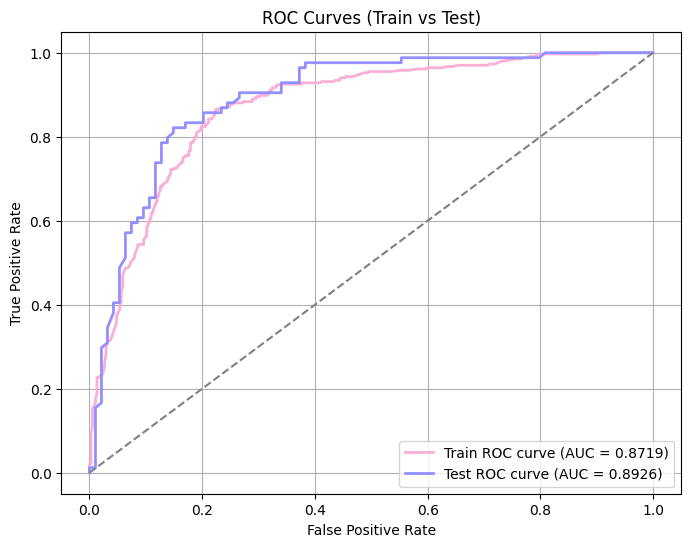

In [135]:
## ROC curves
# predicted probabilities for the positive class (Malignant = 1)
y_train_prob = best_logreg_no_density.predict_proba(X_train_no_density)[:, 1]
y_test_prob = best_logreg_no_density.predict_proba(X_test_no_density)[:, 1]

# train set
fpr_train, tpr_train, _ = roc_curve(y_train_no_density, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# test set
fpr_test, tpr_test, _ = roc_curve(y_test_no_density, y_test_prob)
roc_auc_test_logreg_no_density = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (Logistic Regression): {roc_auc_train:.4f}")
print(f"Test ROC AUC (Logistic Regression): {roc_auc_test_logreg_no_density:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color= '#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_logreg_no_density:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [136]:
## SVM

pipeline_svm_no_density = Pipeline([
    ('scaler', scaler),
    ('svm', SVC(kernel='rbf', probability=True))
])

param_grid = {
    'svm__C': [0.01,0.1, 1, 10],  # Regularization
    'svm__gamma': ['scale', 'auto', 0.01, 0.001]  # Scales for kernel RBF
}

grid_search_svm_no_density = GridSearchCV(pipeline_svm_no_density, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_svm_no_density.fit(X_train_no_density, y_train_no_density)

best_params_svm_no_density = grid_search_svm_no_density.best_params_
print(f"Best Hyperparameters (SVM): {best_params_svm_no_density}")

Best Hyperparameters (SVM): {'svm__C': 10, 'svm__gamma': 'scale'}


Train Accuracy (Logistic Regression): 0.8336
Test Accuracy (Logistic Regression): 0.8034


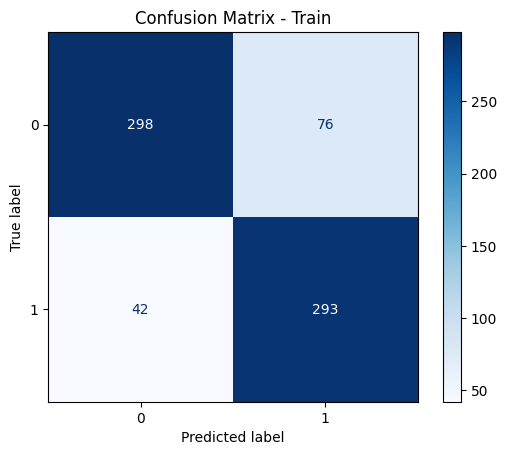

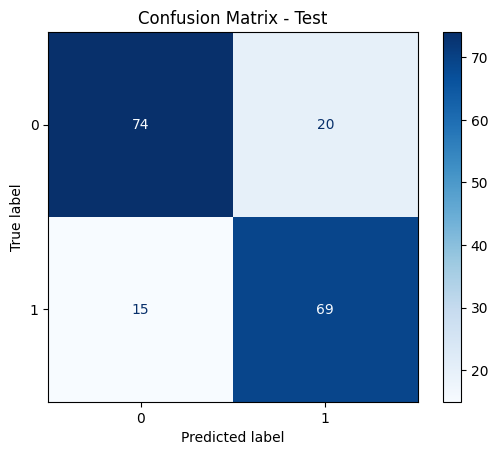

In [137]:
## Train with best parameters

best_svm_no_density = grid_search_svm_no_density.best_estimator_ 
best_svm_no_density.fit(X_train_no_density, y_train_no_density)

# Predict on train and test
y_train_pred_svm = best_svm_no_density.predict(X_train_no_density)
svm_pred_no_density = best_svm_no_density.predict(X_test_no_density)

# Accuracy on train and test
train_accuracy = accuracy_score(y_train_no_density, y_train_pred_svm)
test_accuracy = accuracy_score(y_test_no_density, svm_pred_no_density)

print(f"Train Accuracy (Logistic Regression): {train_accuracy:.4f}")
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")

# Confusion Matrix on train and test
train_cm = confusion_matrix(y_train_no_density, y_train_pred_svm)
test_cm = confusion_matrix(y_test_no_density, svm_pred_no_density)

# Display Confusion Matrices
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test")
plt.show()

Train ROC AUC (SVM): 0.8719
Test ROC AUC (SVM): 0.8926


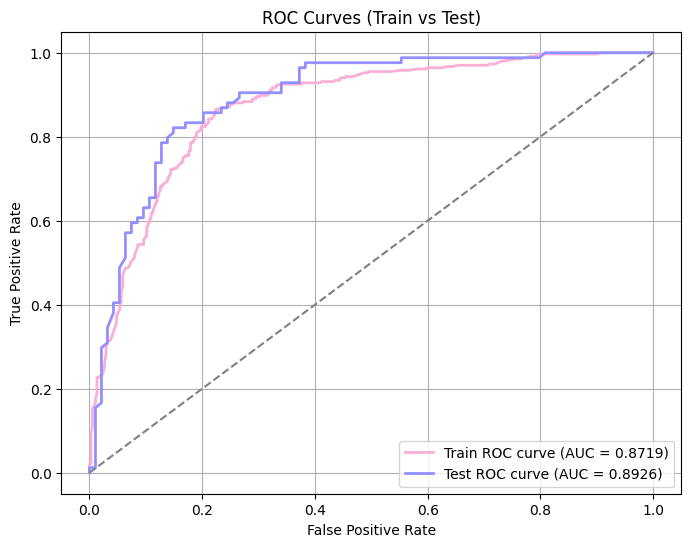

In [138]:
## ROC curves
# predicted probabilities for the positive class (Malignant = 1)
y_train_prob_svm = best_logreg_no_density.predict_proba(X_train_no_density)[:, 1]
y_test_prob_svm = best_logreg_no_density.predict_proba(X_test_no_density)[:, 1]

# train set
fpr_train, tpr_train, _ = roc_curve(y_train_no_density, y_train_prob_svm)
roc_auc_train = auc(fpr_train, tpr_train)

# test set
fpr_test, tpr_test, _ = roc_curve(y_test_no_density, y_test_prob_svm)
roc_auc_test_svm_no_density = auc(fpr_test, tpr_test)

print(f"Train ROC AUC (SVM): {roc_auc_train:.4f}")
print(f"Test ROC AUC (SVM): {roc_auc_test_svm_no_density:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color= '#f9afd7ff', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='#9290ffff', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test_svm_no_density:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train vs Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [139]:
# Logistic Regression
logreg_metrics = {
    'Accuracy': accuracy_score(y_test, logreg_pred),
    'Precision': precision_score(y_test, logreg_pred),
    'Recall': recall_score(y_test, logreg_pred),
    'F1 Score': f1_score(y_test, logreg_pred),
    'AUC': roc_auc_test_logreg
}

# SVM
svm_metrics = {
    'Accuracy': accuracy_score(y_test, svm_pred),
    'Precision': precision_score(y_test, svm_pred),
    'Recall': recall_score(y_test, svm_pred),
    'F1 Score': f1_score(y_test, svm_pred),
    'AUC': roc_auc_test_svm
}

# NN
nn_metrics = {
    'Accuracy': accuracy_score(y_test, nn_pred),
    'Precision': precision_score(y_test, nn_pred),
    'Recall': recall_score(y_test, nn_pred),
    'F1 Score': f1_score(y_test, nn_pred),
    'AUC': roc_auc_test_nn
}

# DT
dt_metrics = {
    'Accuracy': accuracy_score(y_test, dt_pred),
    'Precision': precision_score(y_test, dt_pred),
    'Recall': recall_score(y_test, dt_pred),
    'F1 Score': f1_score(y_test, dt_pred),
    'AUC': roc_auc_test_dt
}

# Logistic Regression
logreg_no_density_metrics = {
    'Accuracy': accuracy_score(y_test_no_density, logreg_pred_no_density),
    'Precision': precision_score(y_test_no_density, logreg_pred_no_density),
    'Recall': recall_score(y_test_no_density, logreg_pred_no_density),
    'F1 Score': f1_score(y_test_no_density, logreg_pred_no_density),
    'AUC': roc_auc_test_logreg_no_density
}

# SVM
svm_no_density_metrics = {
    'Accuracy': accuracy_score(y_test_no_density, svm_pred_no_density),
    'Precision': precision_score(y_test_no_density, svm_pred_no_density),
    'Recall': recall_score(y_test_no_density, svm_pred_no_density),
    'F1 Score': f1_score(y_test_no_density, svm_pred_no_density),
    'AUC': roc_auc_test_logreg_no_density
}

metrics_table = pd.DataFrame([
    {'Model': 'Logistic Regression', **logreg_metrics},
    {'Model': 'SVM', **svm_metrics},
    {'Model': 'Neural Network', **nn_metrics},
    {'Model': 'Decision Tree', **dt_metrics},
    {'Model': 'Logistic Regression (No Density)', **logreg_no_density_metrics},
    {'Model': 'SVM (No Density)', **svm_no_density_metrics}
])

metrics_table = metrics_table.round(4)
metrics_table.set_index('Model', inplace=True)

styled_table = metrics_table.style.highlight_max(axis=0, color='lightgreen') \
                                .format("{:.4f}")

styled_table

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Logistic Regression,0.7784,0.7683,0.7778,0.7730,0.8508
SVM,0.7725,0.7529,0.7901,0.7711,0.8378
Neural Network,0.7784,0.7683,0.7778,0.7730,0.8455
Decision Tree,0.7725,0.7590,0.7778,0.7683,0.8404
Logistic Regression (No Density),0.8202,0.7826,0.8571,0.8182,0.8926
SVM (No Density),0.8034,0.7753,0.8214,0.7977,0.8926
